# Projeto Final - MC886
### Titulo: Como a mobilidade urbana se relaciona com o aumento de numero de casos de covid.

In [1]:
# imports
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense


# %matplotlib notebook

### Carrega dados de Mobilidade do Google

In [2]:
gmr_df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')
gmr_df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [475]:
# Categories available
categories_google_mobility = ['retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline']

regions_list_BR = [ 'Federal District', 'State of Acre','State of Alagoas','State of Amapá', 'State of Amazonas', 
                    'State of Bahia', 'State of Ceará', 'State of Espírito Santo', 'State of Goiás',
                    'State of Maranhão', 'State of Mato Grosso', 'State of Mato Grosso do Sul', 'State of Minas Gerais',
                    'State of Pará', 'State of Paraíba', 'State of Paraná', 'State of Pernambuco', 'State of Piauí', 
                    'State of Rio de Janeiro', 'State of Rio Grande do Norte',
                    'State of Rio Grande do Sul', 'State of Rondônia', 'State of Roraima', 'State of Santa Catarina', 
                    'State of São Paulo', 'State of Sergipe', 'State of Tocantins'
                  ]

regions_abbr_BR = [ 'DF','AC','AL','AP','AM','BA','CE','ES','GO','MA','MT','MS','MG','PA',
                    'PB','PR','PE','PI','RJ','RN','RS','RO','RR','SC','SP','SE','TO']


In [476]:
def getAllRegionsGroups(regions_list=regions_list_BR, country="Brazil"):
    regions_dict = {}
#     print(regions_list)
    for r in regions_list:
        sub_df = gmr_df[(gmr_df['country_region']== country) & (gmr_df['sub_region_1']==r) & (pd.isnull(gmr_df['sub_region_2']))]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[r]=sub_df
#     print(regions_dict)
    return regions_dict

def getCityGroups(cities_list, country="Brazil"):
    regions_dict = {}
#     print(regions_list)
    for r in cities_list:
        sub_df = gmr_df[(gmr_df['country_region']== country) & (gmr_df['sub_region_2']==r)]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[r]=sub_df
#     print(regions_dict)
    return regions_dict


def plotGroups(sub_df, region, country="Brazil"):
    # let's plot all time series for this region
    for group in categories_google_mobility:
        fig, ax = plt.subplots(figsize=(16, 4))
        plt.plot(sub_df['date'], sub_df[group], label=group)
        ax.axhline(y=0, color='gray')
        ax.axvline(pd.to_datetime('2020-03-10'), color='r', linestyle='--', lw=2)
        plt.title(country + ' '+ region + ': ' + group)
        plt.legend(loc='best') 
        plt.grid()
        plt.show()
        

In [477]:
# - - - - - - - -  CASOS DE COVID - - - - - - - -  
covid_df = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv')
col = [ 'epi_week', 'date', 'country', 'state', 'city', 'newDeaths', 'deaths', 'newCases', 'totalCases', 
        'deathsMS', 'totalCasesMS', 'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants', 
        'deaths_by_totalCases', 
        'recovered', 'suspects', 'tests', 'tests_per_100k_inhabitants', 'vaccinated', 
        'vaccinated_per_100_inhabitants', 'vaccinated_second', 
        'vaccinated_second_per_100_inhabitants', 'vaccinated_single', 'vaccinated_single_per_100_inhabitants']

# print(covid_df.head)

def getAllRegionsCovid(regions_list=regions_list_BR, regions_abbr=regions_abbr_BR,
                       country="Brazil"):
    regions_dict = {}
    
    for r in range(len(regions_list)):
        sub_df = covid_df[(covid_df['state']== regions_abbr[r])]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[regions_list[r]]=sub_df
    return regions_dict


    

In [478]:
def getData():
    cases_df = getAllRegionsCovid(regions_list_BR,regions_abbr_BR)
    mob_df = getAllRegionsGroups(regions_list_BR)
    
    mobility_all = []
    cases_all = []
    mobility_dates = []
    cases_dates = []
    mobility_dict = {}
    cases_dict = {}
    mob_date_dict = {}
    cases_date_dict = {}
    
    for r in regions_list_BR:
        newCases = cases_df[r]['newCases'].values
        newCases_norm = newCases/np.max(newCases)
        scaler = MinMaxScaler(feature_range=(-1,1))        
        mobility_norm = scaler.fit_transform(mob_df[r][categories_google_mobility].values)
        
        covid_dates = cases_df[r]['date'].values
        
        mob_dates = mob_df[r]['date'].values
        mob_dates += np.timedelta64(7,'D') # com offset de 7 dias
        
        mobility_dict[r] = mobility_norm
        cases_dict[r] = newCases_norm
        
        mob_date_dict[r] = mob_df[r]['date'].values
        cases_date_dict[r] = cases_df[r]['date'].values
        
        for i in range(len(newCases_norm)):
#             if covid_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
            cases_all.append(newCases_norm[i]) 
            cases_dates.append(covid_dates[i])
            
        for i in range(len(mobility_norm)):
#             if mob_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
            mobility_all.append(mobility_norm[i])
            mobility_dates.append(mob_dates[i])

    Y_data = (np.array([cases_all]).T)
    X_data = np.array(mobility_all)    
    
    
    return X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict,mob_date_dict,cases_date_dict


X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict,mob_date_dict,cases_date_dict = getData()

print(X_data.shape)
print(Y_data.shape)

(13959, 6)
(13308, 1)


In [479]:
# count_gp = 0

# for group in categories_google_mobility:
#     print(group)
#     group_values = X_data[:,count_gp]
#     fig, ax = plt.subplots(figsize=(8, 4))
#     plt.plot(cases_dates[:], Y_data[:], label="new_cases")
#     plt.plot(mobility_dates[:], group_values[:], label=group)
   
#     plt.legend(loc='best') 
#     plt.grid()
#     plt.show()
    
#     count_gp+=1

In [480]:
def getCorrespondentData(X_data,Y_data, mob_dates=[],c_dates=[]):
    i = 0
    j = 0
    X_f = []
    Y_f = []
    while (i < len(mob_dates)) and (j < len(c_dates)):
#         print(mobility_dates[i]," - ", cases_dates[j])
        if mob_dates[i] == c_dates[j]:
            if not np.any(np.isnan(X_data[i])) and not np.isnan(Y_data[j]):
                X_f.append(X_data[i])
                Y_f.append(Y_data[j])
            i+=1
            j+=1
        elif c_dates[j] > (mob_dates[i] + np.timedelta64(20,'W')):
            j+=1
        elif (mob_dates[i] < c_dates[j]) or mob_dates[i] > (c_dates[j] + np.timedelta64(20,'W')):
            i += 1
        elif (mob_dates[i] > c_dates[j]):
            j += 1
             
    return np.array(X_f), np.array(Y_f)

In [481]:
X_filter, Y_filter = getCorrespondentData(X_data,Y_data, mobility_dates,cases_dates)
print(X_filter.shape)
print(Y_filter.shape)

# i = 0

# for group in categories_google_mobility:
#     print(group)
#     group_values = X_filter[:,i]
#     fig, ax = plt.subplots(figsize=(16, 4))
#     plt.scatter(group_values[:], Y_filter[:], label=group) #com offset de 7 dias
# #     plt.scatter(group_values[-460:], newCases_norm[-463:-3], label=group) #sem offset de 7 dias 
   
#     plt.legend(loc='best') 
#     plt.grid()
#     plt.show()
    
#     i+=1

(13185, 6)
(13185, 1)


In [482]:

X_train = X_filter[:9200]
Y_train = Y_filter[:9200]
X_test = X_filter[9200:]
Y_test = Y_filter[9200:]
# X = mobility_norm[-460:,:]
# Y = newCases_norm[-470:-10]
# Y = Y.reshape((len(Y),1))

print("Mobility Features")
print(X_train[:5])
print("X shape: ",X_train.shape)


print("Covid Cases")
print(Y_train[:5])
print("Y shape: ",Y_train.shape)


print("MobilitY_test Features")
print(X_test[:5])
print("X_test shape: ",X_test.shape)
print("Teste ",regions_list_BR[21])

print("Covid Cases")
print(Y_test[:5])
print("Y_test shape: ",Y_test.shape)

Mobility Features
[[ 0.6344086   0.0483871  -0.35403727  0.45679012  0.56190476 -0.5       ]
 [ 0.6344086   0.16129032 -0.36645963  0.48148148  0.46666667 -0.4375    ]
 [ 0.5483871  -0.0483871  -0.22981366  0.80246914  0.86666667 -0.8125    ]
 [ 0.69892473  0.11290323 -0.04347826  0.85185185  0.86666667 -0.875     ]
 [ 0.65591398  0.08064516 -0.0310559   0.82716049  0.86666667 -0.875     ]]
X shape:  (9200, 6)
Covid Cases
[[0.00031536]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.00031536]]
Y shape:  (9200, 1)
MobilitY_test Features
[[ 0.04255319  0.26315789 -0.54081633 -0.02857143  0.39784946 -0.29032258]
 [ 0.          0.18796992 -0.51020408 -0.06666667  0.31182796 -0.22580645]
 [ 0.06382979  0.26315789 -0.53061224 -0.04761905  0.33333333 -0.22580645]
 [ 0.10638298  0.33834586 -0.46938776 -0.02857143  0.37634409 -0.22580645]
 [-0.12765957  0.33834586 -0.54081633 -0.2         0.07526882  0.09677419]]
X_test shape:  (3985, 6)
Teste  State of Rondônia
Covid Cases
[[0.08568318]
 [0.3810

In [483]:
model = Sequential()
model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='relu'))

In [484]:


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, validation_split=0.15, epochs=700, batch_size=180, shuffle=True)



Epoch 1/700
44/44 [==============================] - 1s 6ms/step - loss: 0.6310 - accuracy: 0.0146 - val_loss: 0.5548 - val_accuracy: 0.0138
Epoch 2/700
44/44 [==============================] - 0s 997us/step - loss: 0.5407 - accuracy: 0.0141 - val_loss: 0.5440 - val_accuracy: 0.0138
Epoch 3/700
44/44 [==============================] - 0s 974us/step - loss: 0.5308 - accuracy: 0.0148 - val_loss: 0.5393 - val_accuracy: 0.0138
Epoch 4/700
44/44 [==============================] - 0s 997us/step - loss: 0.5260 - accuracy: 0.0166 - val_loss: 0.5362 - val_accuracy: 0.0138
Epoch 5/700
44/44 [==============================] - 0s 951us/step - loss: 0.5250 - accuracy: 0.0146 - val_loss: 0.5339 - val_accuracy: 0.0138
Epoch 6/700
44/44 [==============================] - 0s 974us/step - loss: 0.5231 - accuracy: 0.0159 - val_loss: 0.5334 - val_accuracy: 0.0138
Epoch 7/700
44/44 [==============================] - 0s 1ms/step - loss: 0.5176 - accuracy: 0.0159 - val_loss: 0.5317 - val_accuracy: 0.0138
Epo

44/44 [==============================] - 0s 974us/step - loss: 0.4980 - accuracy: 0.0142 - val_loss: 0.5147 - val_accuracy: 0.0138
Epoch 59/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4979 - accuracy: 0.0138 - val_loss: 0.5128 - val_accuracy: 0.0138
Epoch 60/700
44/44 [==============================] - 0s 1ms/step - loss: 0.5009 - accuracy: 0.0146 - val_loss: 0.5144 - val_accuracy: 0.0138
Epoch 61/700
44/44 [==============================] - 0s 951us/step - loss: 0.4989 - accuracy: 0.0152 - val_loss: 0.5162 - val_accuracy: 0.0138
Epoch 62/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4996 - accuracy: 0.0151 - val_loss: 0.5162 - val_accuracy: 0.0138
Epoch 63/700
44/44 [==============================] - 0s 997us/step - loss: 0.5027 - accuracy: 0.0150 - val_loss: 0.5144 - val_accuracy: 0.0138
Epoch 64/700
44/44 [==============================] - 0s 974us/step - loss: 0.4954 - accuracy: 0.0141 - val_loss: 0.5191 - val_accuracy: 0.0138
Epoch 65/70

Epoch 115/700
44/44 [==============================] - 0s 951us/step - loss: 0.4945 - accuracy: 0.0129 - val_loss: 0.5157 - val_accuracy: 0.0138
Epoch 116/700
44/44 [==============================] - 0s 928us/step - loss: 0.4983 - accuracy: 0.0152 - val_loss: 0.5193 - val_accuracy: 0.0138
Epoch 117/700
44/44 [==============================] - 0s 974us/step - loss: 0.4997 - accuracy: 0.0155 - val_loss: 0.5153 - val_accuracy: 0.0138
Epoch 118/700
44/44 [==============================] - 0s 928us/step - loss: 0.4958 - accuracy: 0.0135 - val_loss: 0.5184 - val_accuracy: 0.0138
Epoch 119/700
44/44 [==============================] - 0s 951us/step - loss: 0.4955 - accuracy: 0.0153 - val_loss: 0.5155 - val_accuracy: 0.0138
Epoch 120/700
44/44 [==============================] - 0s 951us/step - loss: 0.4947 - accuracy: 0.0147 - val_loss: 0.5154 - val_accuracy: 0.0138
Epoch 121/700
44/44 [==============================] - 0s 928us/step - loss: 0.4927 - accuracy: 0.0197 - val_loss: 0.5154 - val_ac

44/44 [==============================] - 0s 951us/step - loss: 0.5036 - accuracy: 0.0146 - val_loss: 0.5150 - val_accuracy: 0.0138
Epoch 172/700
44/44 [==============================] - 0s 951us/step - loss: 0.5015 - accuracy: 0.0148 - val_loss: 0.5148 - val_accuracy: 0.0138
Epoch 173/700
44/44 [==============================] - 0s 974us/step - loss: 0.5018 - accuracy: 0.0142 - val_loss: 0.5156 - val_accuracy: 0.0138
Epoch 174/700
44/44 [==============================] - 0s 951us/step - loss: 0.5017 - accuracy: 0.0152 - val_loss: 0.5150 - val_accuracy: 0.0138
Epoch 175/700
44/44 [==============================] - 0s 951us/step - loss: 0.5022 - accuracy: 0.0143 - val_loss: 0.5152 - val_accuracy: 0.0138
Epoch 176/700
44/44 [==============================] - 0s 951us/step - loss: 0.4973 - accuracy: 0.0144 - val_loss: 0.5160 - val_accuracy: 0.0138
Epoch 177/700
44/44 [==============================] - 0s 951us/step - loss: 0.4986 - accuracy: 0.0147 - val_loss: 0.5154 - val_accuracy: 0.0138

44/44 [==============================] - 0s 997us/step - loss: 0.4943 - accuracy: 0.0152 - val_loss: 0.5169 - val_accuracy: 0.0138
Epoch 228/700
44/44 [==============================] - 0s 974us/step - loss: 0.4976 - accuracy: 0.0158 - val_loss: 0.5168 - val_accuracy: 0.0138
Epoch 229/700
44/44 [==============================] - 0s 951us/step - loss: 0.4926 - accuracy: 0.0151 - val_loss: 0.5169 - val_accuracy: 0.0138
Epoch 230/700
44/44 [==============================] - 0s 974us/step - loss: 0.4951 - accuracy: 0.0150 - val_loss: 0.5166 - val_accuracy: 0.0138
Epoch 231/700
44/44 [==============================] - 0s 974us/step - loss: 0.4997 - accuracy: 0.0154 - val_loss: 0.5173 - val_accuracy: 0.0138
Epoch 232/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4946 - accuracy: 0.0149 - val_loss: 0.5167 - val_accuracy: 0.0138
Epoch 233/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4972 - accuracy: 0.0152 - val_loss: 0.5163 - val_accuracy: 0.0138
Epo

44/44 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.0168 - val_loss: 0.5173 - val_accuracy: 0.0138
Epoch 285/700
44/44 [==============================] - 0s 997us/step - loss: 0.4888 - accuracy: 0.0151 - val_loss: 0.5192 - val_accuracy: 0.0138
Epoch 286/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4971 - accuracy: 0.0162 - val_loss: 0.5181 - val_accuracy: 0.0138
Epoch 287/700
44/44 [==============================] - 0s 974us/step - loss: 0.4922 - accuracy: 0.0156 - val_loss: 0.5177 - val_accuracy: 0.0138
Epoch 288/700
44/44 [==============================] - 0s 951us/step - loss: 0.4948 - accuracy: 0.0160 - val_loss: 0.5175 - val_accuracy: 0.0138
Epoch 289/700
44/44 [==============================] - 0s 951us/step - loss: 0.4988 - accuracy: 0.0164 - val_loss: 0.5186 - val_accuracy: 0.0138
Epoch 290/700
44/44 [==============================] - 0s 974us/step - loss: 0.4912 - accuracy: 0.0176 - val_loss: 0.5187 - val_accuracy: 0.0138
Epo

Epoch 341/700
44/44 [==============================] - 0s 997us/step - loss: 0.4924 - accuracy: 0.0161 - val_loss: 0.5182 - val_accuracy: 0.0138
Epoch 342/700
44/44 [==============================] - 0s 974us/step - loss: 0.4894 - accuracy: 0.0168 - val_loss: 0.5172 - val_accuracy: 0.0138
Epoch 343/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4899 - accuracy: 0.0129 - val_loss: 0.5167 - val_accuracy: 0.0138
Epoch 344/700
44/44 [==============================] - 0s 997us/step - loss: 0.4919 - accuracy: 0.0164 - val_loss: 0.5176 - val_accuracy: 0.0138
Epoch 345/700
44/44 [==============================] - 0s 974us/step - loss: 0.4945 - accuracy: 0.0161 - val_loss: 0.5173 - val_accuracy: 0.0138
Epoch 346/700
44/44 [==============================] - 0s 974us/step - loss: 0.4914 - accuracy: 0.0171 - val_loss: 0.5166 - val_accuracy: 0.0138
Epoch 347/700
44/44 [==============================] - 0s 951us/step - loss: 0.4924 - accuracy: 0.0145 - val_loss: 0.5178 - val_accu

Epoch 398/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4916 - accuracy: 0.0161 - val_loss: 0.5172 - val_accuracy: 0.0138
Epoch 399/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4930 - accuracy: 0.0182 - val_loss: 0.5166 - val_accuracy: 0.0138
Epoch 400/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4935 - accuracy: 0.0170 - val_loss: 0.5182 - val_accuracy: 0.0138
Epoch 401/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4923 - accuracy: 0.0150 - val_loss: 0.5179 - val_accuracy: 0.0138
Epoch 402/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4926 - accuracy: 0.0149 - val_loss: 0.5161 - val_accuracy: 0.0138
Epoch 403/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4962 - accuracy: 0.0155 - val_loss: 0.5163 - val_accuracy: 0.0138
Epoch 404/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4917 - accuracy: 0.0163 - val_loss: 0.5171 - val_accuracy: 0.0138

Epoch 455/700
44/44 [==============================] - 0s 928us/step - loss: 0.4919 - accuracy: 0.0169 - val_loss: 0.5162 - val_accuracy: 0.0138
Epoch 456/700
44/44 [==============================] - 0s 951us/step - loss: 0.4957 - accuracy: 0.0131 - val_loss: 0.5176 - val_accuracy: 0.0138
Epoch 457/700
44/44 [==============================] - 0s 951us/step - loss: 0.4909 - accuracy: 0.0135 - val_loss: 0.5167 - val_accuracy: 0.0138
Epoch 458/700
44/44 [==============================] - 0s 974us/step - loss: 0.4953 - accuracy: 0.0163 - val_loss: 0.5163 - val_accuracy: 0.0138
Epoch 459/700
44/44 [==============================] - 0s 951us/step - loss: 0.4984 - accuracy: 0.0144 - val_loss: 0.5164 - val_accuracy: 0.0138
Epoch 460/700
44/44 [==============================] - 0s 951us/step - loss: 0.4946 - accuracy: 0.0152 - val_loss: 0.5161 - val_accuracy: 0.0138
Epoch 461/700
44/44 [==============================] - 0s 1ms/step - loss: 0.4939 - accuracy: 0.0155 - val_loss: 0.5160 - val_accu

44/44 [==============================] - 0s 928us/step - loss: 0.4882 - accuracy: 0.0150 - val_loss: 0.5194 - val_accuracy: 0.0138
Epoch 512/700
44/44 [==============================] - 0s 974us/step - loss: 0.4849 - accuracy: 0.0148 - val_loss: 0.5185 - val_accuracy: 0.0138
Epoch 513/700
44/44 [==============================] - 0s 951us/step - loss: 0.4949 - accuracy: 0.0170 - val_loss: 0.5176 - val_accuracy: 0.0138
Epoch 514/700
44/44 [==============================] - 0s 974us/step - loss: 0.4896 - accuracy: 0.0160 - val_loss: 0.5172 - val_accuracy: 0.0138
Epoch 515/700
44/44 [==============================] - 0s 997us/step - loss: 0.4904 - accuracy: 0.0179 - val_loss: 0.5163 - val_accuracy: 0.0138
Epoch 516/700
44/44 [==============================] - 0s 951us/step - loss: 0.4911 - accuracy: 0.0136 - val_loss: 0.5158 - val_accuracy: 0.0138
Epoch 517/700
44/44 [==============================] - 0s 997us/step - loss: 0.4881 - accuracy: 0.0141 - val_loss: 0.5157 - val_accuracy: 0.0138

44/44 [==============================] - 0s 974us/step - loss: 0.4876 - accuracy: 0.0160 - val_loss: 0.5174 - val_accuracy: 0.0138
Epoch 568/700
44/44 [==============================] - 0s 928us/step - loss: 0.4883 - accuracy: 0.0164 - val_loss: 0.5167 - val_accuracy: 0.0138
Epoch 569/700
44/44 [==============================] - 0s 997us/step - loss: 0.4931 - accuracy: 0.0143 - val_loss: 0.5177 - val_accuracy: 0.0138
Epoch 570/700
44/44 [==============================] - 0s 951us/step - loss: 0.4891 - accuracy: 0.0154 - val_loss: 0.5158 - val_accuracy: 0.0138
Epoch 571/700
44/44 [==============================] - 0s 951us/step - loss: 0.4881 - accuracy: 0.0167 - val_loss: 0.5195 - val_accuracy: 0.0138
Epoch 572/700
44/44 [==============================] - 0s 974us/step - loss: 0.4914 - accuracy: 0.0160 - val_loss: 0.5171 - val_accuracy: 0.0138
Epoch 573/700
44/44 [==============================] - 0s 951us/step - loss: 0.4866 - accuracy: 0.0134 - val_loss: 0.5197 - val_accuracy: 0.0138

44/44 [==============================] - 0s 974us/step - loss: 0.4868 - accuracy: 0.0173 - val_loss: 0.5172 - val_accuracy: 0.0138
Epoch 624/700
44/44 [==============================] - 0s 951us/step - loss: 0.4923 - accuracy: 0.0126 - val_loss: 0.5162 - val_accuracy: 0.0138
Epoch 625/700
44/44 [==============================] - 0s 951us/step - loss: 0.4920 - accuracy: 0.0141 - val_loss: 0.5170 - val_accuracy: 0.0138
Epoch 626/700
44/44 [==============================] - 0s 974us/step - loss: 0.4893 - accuracy: 0.0129 - val_loss: 0.5168 - val_accuracy: 0.0138
Epoch 627/700
44/44 [==============================] - 0s 951us/step - loss: 0.4879 - accuracy: 0.0158 - val_loss: 0.5182 - val_accuracy: 0.0138
Epoch 628/700
44/44 [==============================] - 0s 974us/step - loss: 0.4888 - accuracy: 0.0149 - val_loss: 0.5196 - val_accuracy: 0.0138
Epoch 629/700
44/44 [==============================] - 0s 951us/step - loss: 0.4926 - accuracy: 0.0156 - val_loss: 0.5177 - val_accuracy: 0.0138

44/44 [==============================] - 0s 974us/step - loss: 0.4865 - accuracy: 0.0156 - val_loss: 0.5186 - val_accuracy: 0.0138
Epoch 680/700
44/44 [==============================] - 0s 974us/step - loss: 0.4856 - accuracy: 0.0152 - val_loss: 0.5174 - val_accuracy: 0.0138
Epoch 681/700
44/44 [==============================] - 0s 928us/step - loss: 0.4843 - accuracy: 0.0163 - val_loss: 0.5192 - val_accuracy: 0.0138
Epoch 682/700
44/44 [==============================] - 0s 951us/step - loss: 0.4930 - accuracy: 0.0122 - val_loss: 0.5184 - val_accuracy: 0.0138
Epoch 683/700
44/44 [==============================] - 0s 951us/step - loss: 0.4911 - accuracy: 0.0152 - val_loss: 0.5168 - val_accuracy: 0.0138
Epoch 684/700
44/44 [==============================] - 0s 974us/step - loss: 0.4908 - accuracy: 0.0159 - val_loss: 0.5176 - val_accuracy: 0.0138
Epoch 685/700
44/44 [==============================] - 0s 951us/step - loss: 0.4824 - accuracy: 0.0177 - val_loss: 0.5171 - val_accuracy: 0.0138

In [485]:
print(categories_google_mobility)
print(len(model.get_weights()))
print(model.get_weights()[0])
print(model.get_weights()[1])
print(model.get_weights()[2])
print(model.get_weights()[3])
print(model.get_weights()[4])
print(model.get_weights()[5])
print(model.get_weights()[6])
print(model.get_weights()[7])
print(model.get_weights()[8])
print(model.get_weights()[9])

['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']
10
[[-0.38112238  0.14818977 -0.40289778  0.05576615  0.08429395  0.06926827]
 [ 0.04143732 -0.08560519  0.10702275  0.01828532  0.91380024 -0.17073897]
 [-0.08389628  0.47600964  0.06070548 -0.08969351 -0.22645041  0.7968412 ]
 [-0.24320243 -0.3865127   0.5878212  -0.89626586 -0.436344    0.5675497 ]
 [-0.6883936   0.6025396   0.8280042   0.390405    0.6022242   0.50189626]
 [-0.45618755 -0.2039663  -0.34304628 -0.19132668  0.62951225  1.2137573 ]]
[ 0.19678642  0.02599163 -0.20238286 -0.04004705  0.18099542  0.13274236]
[[ 0.30874774  0.16656467  0.20166984 -0.21796557 -0.27836433  0.26477453
  -0.70483905  0.28763586  0.7768612   0.1970602  -0.26970473  0.0578176 ]
 [ 0.44390938  0.7320778   0.16473289 -0.

In [486]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train, Y_train)
print('Accuracy: %.2f' % (accuracy*100))

288/288 [==============================] - 0s 424us/step - loss: 0.4922 - accuracy: 0.0151
Accuracy: 1.51


In [487]:
# newCases = cases_df[regions_selected[2]]['newCases'].values
# newCases_norm = newCases/np.max(newCases)
# mobility_norm = scaler.fit_transform(mob_df[regions_selected[2]][categories_google_mobility].values)

In [488]:
# X_test = mobility_norm[-460:,:]
# Y_test = newCases_norm[-470:-10]
# Y_test = Y_test.reshape((len(Y_test),1))
# X_test = mobility_dict[regions_list_BR[21]][-460:,:]
# Y_test = cases_dict[regions_list_BR[21]][-460:]
# Y_test = Y_test.reshape((len(Y_test),1))

print("MobilitY_test Features")
print(X_test[:5])
print("X_test shape: ",X_test.shape)
print("Teste ",regions_list_BR[21])

print("Covid Cases")
print(Y_test[:5])
print("Y_test shape: ",Y_test.shape)

_, accuracY_test = model.evaluate(X_test, Y_test)
print('AccuracY_test: %.2f' % (accuracY_test*100))

MobilitY_test Features
[[ 0.04255319  0.26315789 -0.54081633 -0.02857143  0.39784946 -0.29032258]
 [ 0.          0.18796992 -0.51020408 -0.06666667  0.31182796 -0.22580645]
 [ 0.06382979  0.26315789 -0.53061224 -0.04761905  0.33333333 -0.22580645]
 [ 0.10638298  0.33834586 -0.46938776 -0.02857143  0.37634409 -0.22580645]
 [-0.12765957  0.33834586 -0.54081633 -0.2         0.07526882  0.09677419]]
X_test shape:  (3985, 6)
Teste  State of Rondônia
Covid Cases
[[0.08568318]
 [0.38105607]
 [0.33979314]
 [0.4397387 ]
 [0.14044638]]
Y_test shape:  (3985, 1)
125/125 [==============================] - 0s 426us/step - loss: 0.4735 - accuracy: 0.0371
AccuracY_test: 3.71


In [489]:
def printSaveGraph(X_t,Y_t,pred,imgName,keras_model):
    fig = plt.figure(figsize=(18, 4))
    plt.plot(Y_t,label="Ground Truth")
    plt.plot(pred,label="Predict")
    plt.legend(loc='best')
    plt.savefig(imgName+'.png')
    plt.show()
    
    _, accuracy = keras_model.evaluate(X_t, Y_t)
    print('Accuracy: %.2f' % (accuracy*100))

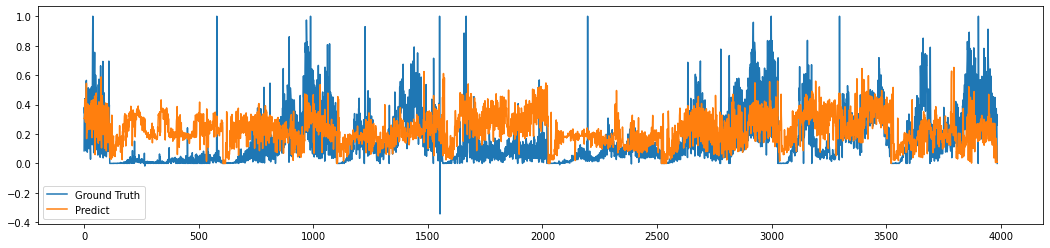

125/125 [==============================] - 0s 426us/step - loss: 0.4735 - accuracy: 0.0371
Accuracy: 3.71


In [490]:
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'BR_test',model)


Teste  State of Rondônia


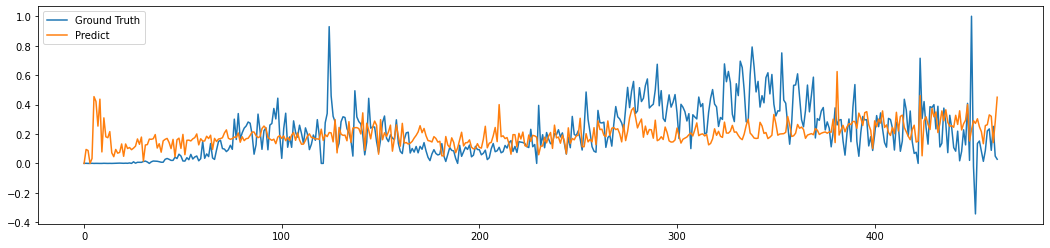

15/15 [==============================] - 0s 784us/step - loss: 0.5130 - accuracy: 0.0324
Accuracy: 3.24


In [491]:

rgName=regions_list_BR[21]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'RO_test',model)

Teste  State of Roraima


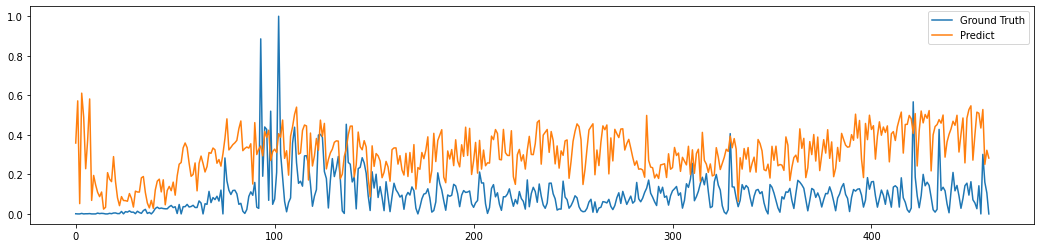

15/15 [==============================] - 0s 784us/step - loss: 0.4478 - accuracy: 0.0348
Accuracy: 3.48


In [492]:
rgName=regions_list_BR[22]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'RR_test',model)

Teste  State of Santa Catarina


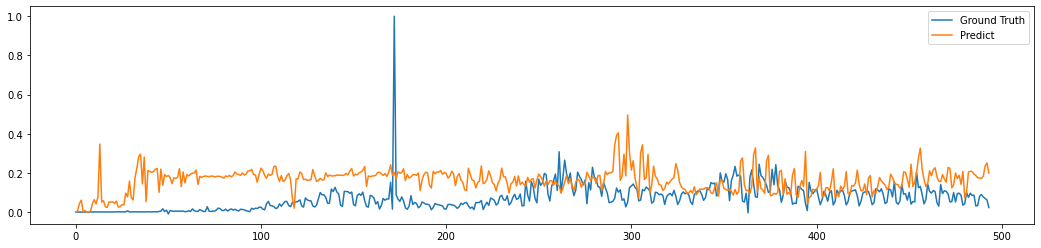

16/16 [==============================] - 0s 798us/step - loss: 0.3002 - accuracy: 0.0020
Accuracy: 0.20


In [493]:
rgName=regions_list_BR[23]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'SC_test',model)

Teste  State of São Paulo


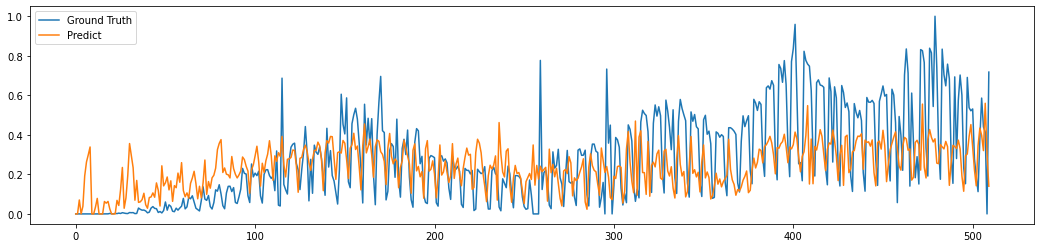

16/16 [==============================] - 0s 798us/step - loss: 0.5587 - accuracy: 0.0275
Accuracy: 2.75


In [494]:
rgName=regions_list_BR[24]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'SP_test',model)

Teste  State of Sergipe


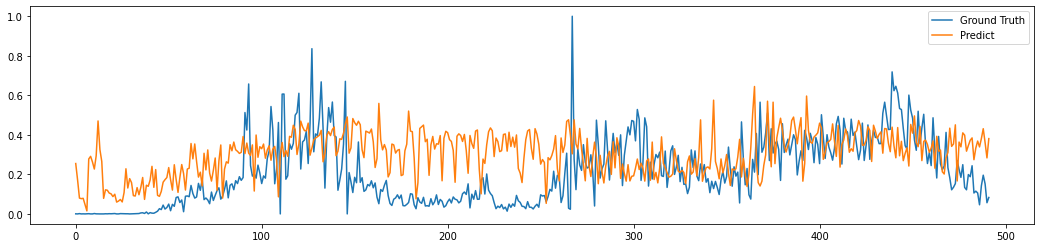

16/16 [==============================] - 0s 798us/step - loss: 0.5353 - accuracy: 0.0285
Accuracy: 2.85


In [495]:
rgName=regions_list_BR[25]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'SE_test',model)

Teste  State of Tocantins


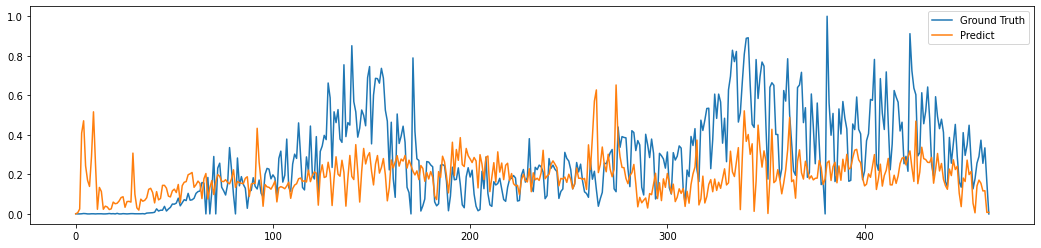

15/15 [==============================] - 0s 926us/step - loss: 0.6066 - accuracy: 0.0409
Accuracy: 4.09


In [496]:
rgName=regions_list_BR[26]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'TO_test',model)

In [548]:
# cities_selected=['São Paulo/SP','Campinas/SP','Guarulhos/SP','São Bernardo do Campo/SP',
#                  'Santo André/SP','Ribeirão Preto/SP','Osasco/SP','Sorocaba/SP','Mauá/SP','São José do Rio Preto/SP',
#                  'Mogi das Cruzes/SP','Santos/SP','Diadema/SP','Jundiaí/SP', 'Piracicaba/SP','Carapicuíba/SP',
#                  'Bauru/SP','Itaquaquecetuba/SP','São Vicente/SP','Franca/SP','Marília/SP']

In [566]:


def getSelectedCities(df,cities_list):
    regions_dict = {}
    
#     print(regions_list)
    for r in cities_list:
        sub_df = df[(df['city']== r)]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[r[:-3]]=sub_df
#     print(regions_dict)
    return regions_dict


cities_cols = ['epi_week','date','country','state',
               'city','ibgeID','newDeaths','deaths','newCases',
               'totalCases','deaths_per_100k_inhabitants',
               'totalCases_per_100k_inhabitants','deaths_by_totalCases','_source','last_info_date'
               ]

cities_selected=['São Bernardo do Campo/SP','Santo André/SP',
                 'Osasco/SP','Sorocaba/SP','Mauá/SP','São José do Rio Preto/SP',
                 'Mogi das Cruzes/SP','Diadema/SP','Jundiaí/SP', 'Piracicaba/SP',
                 'Belo Horizonte/MG','Vitória/ES',
                 'Santos/SP', 'Florianópolis/SC','Salvador/BA','Fortaleza/CE','Recife/PE',
                 'Goiânia/GO','Belém/PA','Guarulhos/SP','São Luís/MA','São Gonçalo/RJ','Maceió/AL',
                 'Duque de Caxias/RJ','Campo Grande/MS','São Paulo/SP',
                 'Porto Alegre/RS','Curitiba/PR','Manaus/AM',
                 'Rio de Janeiro/RJ','Natal/RN','Ribeirão Preto/SP','Campinas/SP']
mob_cities_selected=[i[:-3] for i in cities_selected]
# print(mob_cities_selected)

cities_df = pd.read_csv('cases-brazil-cities-time_changesOnly.csv')
cities_covid = getSelectedCities(cities_df,cities_selected)
mob_cities = getCityGroups(mob_cities_selected)
# print(mob_cities)

In [567]:
def getCitiesData(mob_df,cases_df,cities_list):
    mobility_all = []
    cases_all = []
    mobility_dates = []
    cases_dates = []
    mobility_dict = {}
    cases_dict = {}
    mob_date_dict = {}
    cases_date_dict = {}
    
    for r in cities_list:
        newCases = cases_df[r]['newCases'].values
        newCases_norm = newCases/np.max(newCases)
        scaler = MinMaxScaler(feature_range=(-1,1))        
        mobility_norm = scaler.fit_transform(mob_df[r][categories_google_mobility].values)
        
        covid_dates = cases_df[r]['date'].values
        
        mob_dates = mob_df[r]['date'].values
        mob_dates += np.timedelta64(7,'D') # com offset de 7 dias
        
        mobility_dict[r] = mobility_norm
        cases_dict[r] = newCases_norm
        
        mob_date_dict[r] = mob_df[r]['date'].values
        cases_date_dict[r] = cases_df[r]['date'].values
        
        for i in range(len(newCases_norm)):
#             if covid_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
            cases_all.append(newCases_norm[i]) 
            cases_dates.append(covid_dates[i])
            
        for i in range(len(mobility_norm)):
#             if mob_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
            mobility_all.append(mobility_norm[i])
            mobility_dates.append(mob_dates[i])

    Y_data = (np.array([cases_all]).T)
    X_data = np.array(mobility_all)    
    
    
    return X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict, mob_date_dict, cases_date_dict


Xc_data, Yc_data, mobility_ct_dates, cases_ct_dates, mobility_ct_dict, cases_ct_dict,mob_date_ct_dict, cases_date_ct_dict = getCitiesData(mob_cities,cities_covid,mob_cities_selected)

print(Xc_data.shape)
print(Yc_data.shape)

(17061, 6)
(15150, 1)


In [568]:
Xc_filter, Yc_filter = getCorrespondentData(Xc_data,Yc_data, mobility_ct_dates,cases_ct_dates)
print(Xc_filter.shape)
print(Yc_filter.shape)

Xc_train = Xc_filter[:11000]
Yc_train = Yc_filter[:11000]
Xc_test = Xc_filter[11000:]
Yc_test = Yc_filter[11000:]
# X = mobility_norm[-460:,:]
# Y = newCases_norm[-470:-10]
# Y = Y.reshape((len(Y),1))

print("Mobility Features")
print(Xc_train[:5])
print("X shape: ",Xc_train.shape)


print("Covid Cases")
print(Yc_train[:5])
print("Y shape: ",Yc_train.shape)

(14889, 6)
(14889, 1)
Mobility Features
[[ 6.87500000e-01  2.62411348e-01  1.44927536e-01  2.94964029e-01
   8.83495146e-01 -8.88888889e-01]
 [ 7.91666667e-01  2.19858156e-01  7.24637681e-02  3.38129496e-01
   8.64077670e-01 -9.44444444e-01]
 [ 7.91666667e-01  3.61702128e-01  4.20289855e-01  2.23021583e-01
   9.22330097e-01 -9.44444444e-01]
 [ 2.70833333e-01  3.75886525e-01 -1.59420290e-01 -1.36690647e-01
   3.98058252e-01 -3.33333333e-01]
 [-1.04166667e-01  2.19858156e-01 -2.17391304e-01 -4.67625899e-01
   1.26213592e-01 -1.11022302e-16]]
X shape:  (11000, 6)
Covid Cases
[[0.00093023]
 [0.00186047]
 [0.00093023]
 [0.00837209]
 [0.00186047]]
Y shape:  (11000, 1)


In [569]:

city_model = Sequential()
city_model.add(Dense(6, input_dim=6, activation='relu'))
city_model.add(Dense(12, activation='relu'))
# city_model.add(Dense(12, activation='relu'))
city_model.add(Dense(6, activation='relu'))
city_model.add(Dense(1, activation='relu'))
city_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

city_model.fit(Xc_train, Yc_train, validation_split=0.15,epochs=600, batch_size=180)



Epoch 1/600
52/52 [==============================] - 1s 5ms/step - loss: 0.8112 - accuracy: 0.0085 - val_loss: 0.4093 - val_accuracy: 0.0030
Epoch 2/600
52/52 [==============================] - 0s 919us/step - loss: 0.5121 - accuracy: 0.0077 - val_loss: 0.3854 - val_accuracy: 0.0030
Epoch 3/600
52/52 [==============================] - 0s 919us/step - loss: 0.4824 - accuracy: 0.0085 - val_loss: 0.3829 - val_accuracy: 0.0030
Epoch 4/600
52/52 [==============================] - 0s 919us/step - loss: 0.4653 - accuracy: 0.0089 - val_loss: 0.3854 - val_accuracy: 0.0030
Epoch 5/600
52/52 [==============================] - 0s 919us/step - loss: 0.4598 - accuracy: 0.0080 - val_loss: 0.3871 - val_accuracy: 0.0030
Epoch 6/600
52/52 [==============================] - 0s 900us/step - loss: 0.4632 - accuracy: 0.0080 - val_loss: 0.3874 - val_accuracy: 0.0030
Epoch 7/600
52/52 [==============================] - 0s 939us/step - loss: 0.4666 - accuracy: 0.0074 - val_loss: 0.3886 - val_accuracy: 0.0030
E

Epoch 58/600
52/52 [==============================] - 0s 880us/step - loss: 0.4481 - accuracy: 0.0088 - val_loss: 0.3832 - val_accuracy: 0.0030
Epoch 59/600
52/52 [==============================] - 0s 900us/step - loss: 0.4483 - accuracy: 0.0097 - val_loss: 0.3833 - val_accuracy: 0.0030
Epoch 60/600
52/52 [==============================] - 0s 880us/step - loss: 0.4521 - accuracy: 0.0084 - val_loss: 0.3828 - val_accuracy: 0.0030
Epoch 61/600
52/52 [==============================] - 0s 880us/step - loss: 0.4478 - accuracy: 0.0081 - val_loss: 0.3833 - val_accuracy: 0.0030
Epoch 62/600
52/52 [==============================] - 0s 939us/step - loss: 0.4468 - accuracy: 0.0095 - val_loss: 0.3825 - val_accuracy: 0.0030
Epoch 63/600
52/52 [==============================] - 0s 900us/step - loss: 0.4531 - accuracy: 0.0086 - val_loss: 0.3836 - val_accuracy: 0.0030
Epoch 64/600
52/52 [==============================] - 0s 880us/step - loss: 0.4536 - accuracy: 0.0074 - val_loss: 0.3845 - val_accuracy:

Epoch 115/600
52/52 [==============================] - 0s 880us/step - loss: 0.4514 - accuracy: 0.0080 - val_loss: 0.3819 - val_accuracy: 0.0030
Epoch 116/600
52/52 [==============================] - 0s 900us/step - loss: 0.4502 - accuracy: 0.0080 - val_loss: 0.3801 - val_accuracy: 0.0030
Epoch 117/600
52/52 [==============================] - 0s 880us/step - loss: 0.4498 - accuracy: 0.0088 - val_loss: 0.3803 - val_accuracy: 0.0030
Epoch 118/600
52/52 [==============================] - 0s 880us/step - loss: 0.4479 - accuracy: 0.0085 - val_loss: 0.3810 - val_accuracy: 0.0030
Epoch 119/600
52/52 [==============================] - 0s 880us/step - loss: 0.4497 - accuracy: 0.0070 - val_loss: 0.3816 - val_accuracy: 0.0030
Epoch 120/600
52/52 [==============================] - 0s 880us/step - loss: 0.4517 - accuracy: 0.0083 - val_loss: 0.3813 - val_accuracy: 0.0030
Epoch 121/600
52/52 [==============================] - 0s 860us/step - loss: 0.4468 - accuracy: 0.0097 - val_loss: 0.3827 - val_ac

52/52 [==============================] - 0s 880us/step - loss: 0.4497 - accuracy: 0.0083 - val_loss: 0.3790 - val_accuracy: 0.0030
Epoch 172/600
52/52 [==============================] - 0s 900us/step - loss: 0.4453 - accuracy: 0.0087 - val_loss: 0.3784 - val_accuracy: 0.0030
Epoch 173/600
52/52 [==============================] - 0s 860us/step - loss: 0.4490 - accuracy: 0.0081 - val_loss: 0.3793 - val_accuracy: 0.0030
Epoch 174/600
52/52 [==============================] - 0s 880us/step - loss: 0.4487 - accuracy: 0.0090 - val_loss: 0.3771 - val_accuracy: 0.0030
Epoch 175/600
52/52 [==============================] - 0s 900us/step - loss: 0.4466 - accuracy: 0.0083 - val_loss: 0.3787 - val_accuracy: 0.0030
Epoch 176/600
52/52 [==============================] - 0s 880us/step - loss: 0.4523 - accuracy: 0.0083 - val_loss: 0.3797 - val_accuracy: 0.0030
Epoch 177/600
52/52 [==============================] - 0s 900us/step - loss: 0.4508 - accuracy: 0.0091 - val_loss: 0.3775 - val_accuracy: 0.0030

52/52 [==============================] - 0s 919us/step - loss: 0.4485 - accuracy: 0.0081 - val_loss: 0.3793 - val_accuracy: 0.0030
Epoch 228/600
52/52 [==============================] - 0s 900us/step - loss: 0.4475 - accuracy: 0.0096 - val_loss: 0.3775 - val_accuracy: 0.0030
Epoch 229/600
52/52 [==============================] - 0s 919us/step - loss: 0.4440 - accuracy: 0.0077 - val_loss: 0.3792 - val_accuracy: 0.0030
Epoch 230/600
52/52 [==============================] - 0s 880us/step - loss: 0.4508 - accuracy: 0.0087 - val_loss: 0.3801 - val_accuracy: 0.0030
Epoch 231/600
52/52 [==============================] - 0s 880us/step - loss: 0.4438 - accuracy: 0.0087 - val_loss: 0.3784 - val_accuracy: 0.0030
Epoch 232/600
52/52 [==============================] - 0s 880us/step - loss: 0.4477 - accuracy: 0.0079 - val_loss: 0.3782 - val_accuracy: 0.0030
Epoch 233/600
52/52 [==============================] - 0s 880us/step - loss: 0.4445 - accuracy: 0.0083 - val_loss: 0.3789 - val_accuracy: 0.0030

52/52 [==============================] - 0s 900us/step - loss: 0.4474 - accuracy: 0.0075 - val_loss: 0.3773 - val_accuracy: 0.0030
Epoch 284/600
52/52 [==============================] - 0s 880us/step - loss: 0.4442 - accuracy: 0.0078 - val_loss: 0.3788 - val_accuracy: 0.0030
Epoch 285/600
52/52 [==============================] - 0s 860us/step - loss: 0.4476 - accuracy: 0.0090 - val_loss: 0.3794 - val_accuracy: 0.0030
Epoch 286/600
52/52 [==============================] - 0s 860us/step - loss: 0.4511 - accuracy: 0.0082 - val_loss: 0.3777 - val_accuracy: 0.0030
Epoch 287/600
52/52 [==============================] - 0s 860us/step - loss: 0.4475 - accuracy: 0.0089 - val_loss: 0.3797 - val_accuracy: 0.0030
Epoch 288/600
52/52 [==============================] - 0s 860us/step - loss: 0.4473 - accuracy: 0.0091 - val_loss: 0.3785 - val_accuracy: 0.0030
Epoch 289/600
52/52 [==============================] - 0s 880us/step - loss: 0.4451 - accuracy: 0.0089 - val_loss: 0.3781 - val_accuracy: 0.0030

52/52 [==============================] - 0s 919us/step - loss: 0.4420 - accuracy: 0.0086 - val_loss: 0.3797 - val_accuracy: 0.0030
Epoch 340/600
52/52 [==============================] - 0s 900us/step - loss: 0.4484 - accuracy: 0.0081 - val_loss: 0.3780 - val_accuracy: 0.0030
Epoch 341/600
52/52 [==============================] - 0s 900us/step - loss: 0.4443 - accuracy: 0.0072 - val_loss: 0.3773 - val_accuracy: 0.0030
Epoch 342/600
52/52 [==============================] - 0s 958us/step - loss: 0.4439 - accuracy: 0.0085 - val_loss: 0.3789 - val_accuracy: 0.0030
Epoch 343/600
52/52 [==============================] - 0s 939us/step - loss: 0.4453 - accuracy: 0.0091 - val_loss: 0.3778 - val_accuracy: 0.0030
Epoch 344/600
52/52 [==============================] - 0s 919us/step - loss: 0.4441 - accuracy: 0.0068 - val_loss: 0.3791 - val_accuracy: 0.0030
Epoch 345/600
52/52 [==============================] - 0s 880us/step - loss: 0.4456 - accuracy: 0.0073 - val_loss: 0.3785 - val_accuracy: 0.0030

52/52 [==============================] - 0s 880us/step - loss: 0.4488 - accuracy: 0.0090 - val_loss: 0.3798 - val_accuracy: 0.0030
Epoch 396/600
52/52 [==============================] - 0s 880us/step - loss: 0.4427 - accuracy: 0.0093 - val_loss: 0.3780 - val_accuracy: 0.0030
Epoch 397/600
52/52 [==============================] - 0s 880us/step - loss: 0.4475 - accuracy: 0.0088 - val_loss: 0.3794 - val_accuracy: 0.0030
Epoch 398/600
52/52 [==============================] - 0s 880us/step - loss: 0.4512 - accuracy: 0.0090 - val_loss: 0.3781 - val_accuracy: 0.0030
Epoch 399/600
52/52 [==============================] - 0s 880us/step - loss: 0.4494 - accuracy: 0.0075 - val_loss: 0.3786 - val_accuracy: 0.0030
Epoch 400/600
52/52 [==============================] - 0s 880us/step - loss: 0.4445 - accuracy: 0.0094 - val_loss: 0.3814 - val_accuracy: 0.0030
Epoch 401/600
52/52 [==============================] - 0s 860us/step - loss: 0.4478 - accuracy: 0.0087 - val_loss: 0.3785 - val_accuracy: 0.0030

52/52 [==============================] - 0s 880us/step - loss: 0.4459 - accuracy: 0.0076 - val_loss: 0.3802 - val_accuracy: 0.0030
Epoch 452/600
52/52 [==============================] - 0s 860us/step - loss: 0.4462 - accuracy: 0.0077 - val_loss: 0.3814 - val_accuracy: 0.0030
Epoch 453/600
52/52 [==============================] - 0s 860us/step - loss: 0.4444 - accuracy: 0.0076 - val_loss: 0.3802 - val_accuracy: 0.0030
Epoch 454/600
52/52 [==============================] - 0s 900us/step - loss: 0.4505 - accuracy: 0.0096 - val_loss: 0.3786 - val_accuracy: 0.0030
Epoch 455/600
52/52 [==============================] - 0s 900us/step - loss: 0.4464 - accuracy: 0.0081 - val_loss: 0.3806 - val_accuracy: 0.0030
Epoch 456/600
52/52 [==============================] - 0s 860us/step - loss: 0.4460 - accuracy: 0.0086 - val_loss: 0.3793 - val_accuracy: 0.0030
Epoch 457/600
52/52 [==============================] - 0s 900us/step - loss: 0.4465 - accuracy: 0.0086 - val_loss: 0.3801 - val_accuracy: 0.0030

52/52 [==============================] - 0s 900us/step - loss: 0.4480 - accuracy: 0.0089 - val_loss: 0.3794 - val_accuracy: 0.0030
Epoch 508/600
52/52 [==============================] - 0s 900us/step - loss: 0.4455 - accuracy: 0.0087 - val_loss: 0.3791 - val_accuracy: 0.0030
Epoch 509/600
52/52 [==============================] - 0s 900us/step - loss: 0.4493 - accuracy: 0.0097 - val_loss: 0.3795 - val_accuracy: 0.0030
Epoch 510/600
52/52 [==============================] - 0s 900us/step - loss: 0.4450 - accuracy: 0.0087 - val_loss: 0.3798 - val_accuracy: 0.0030
Epoch 511/600
52/52 [==============================] - 0s 880us/step - loss: 0.4471 - accuracy: 0.0086 - val_loss: 0.3802 - val_accuracy: 0.0030
Epoch 512/600
52/52 [==============================] - 0s 880us/step - loss: 0.4467 - accuracy: 0.0088 - val_loss: 0.3801 - val_accuracy: 0.0030
Epoch 513/600
52/52 [==============================] - 0s 880us/step - loss: 0.4479 - accuracy: 0.0077 - val_loss: 0.3802 - val_accuracy: 0.0030

52/52 [==============================] - 0s 958us/step - loss: 0.4431 - accuracy: 0.0088 - val_loss: 0.3808 - val_accuracy: 0.0030
Epoch 564/600
52/52 [==============================] - 0s 880us/step - loss: 0.4485 - accuracy: 0.0069 - val_loss: 0.3811 - val_accuracy: 0.0030
Epoch 565/600
52/52 [==============================] - 0s 880us/step - loss: 0.4477 - accuracy: 0.0088 - val_loss: 0.3801 - val_accuracy: 0.0030
Epoch 566/600
52/52 [==============================] - 0s 880us/step - loss: 0.4487 - accuracy: 0.0082 - val_loss: 0.3795 - val_accuracy: 0.0030
Epoch 567/600
52/52 [==============================] - 0s 1ms/step - loss: 0.4446 - accuracy: 0.0084 - val_loss: 0.3801 - val_accuracy: 0.0030
Epoch 568/600
52/52 [==============================] - 0s 978us/step - loss: 0.4477 - accuracy: 0.0077 - val_loss: 0.3806 - val_accuracy: 0.0030
Epoch 569/600
52/52 [==============================] - 0s 958us/step - loss: 0.4461 - accuracy: 0.0082 - val_loss: 0.3808 - val_accuracy: 0.0030
E

In [570]:
print(categories_google_mobility)
print(city_model.get_weights()[0])
print(city_model.get_weights()[1])
print(city_model.get_weights()[2])
print(city_model.get_weights()[3])
print(city_model.get_weights()[4])
print(city_model.get_weights()[5])
print(city_model.get_weights()[6])
print(city_model.get_weights()[7])

['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']
[[ 0.10951595  0.5136554  -0.5427688  -0.6474201  -0.4808729   0.23253816]
 [ 0.09820895 -1.0381643   0.8805464  -0.3698208   0.22810206 -0.2823045 ]
 [-0.09169347  0.7694858   0.14405482 -0.05570029  0.07098565 -0.6353732 ]
 [-0.09143427 -0.09936786  0.28981158  0.6984751  -0.9135374  -0.22551604]
 [ 0.4762736   0.02423574 -0.04823136 -0.80885285 -0.38467273 -0.99495524]
 [-0.4614914  -0.9978079   0.9664177  -0.06972589  0.7097508   0.04926018]]
[-0.30280012 -0.01983574  0.15393348  0.12832576  0.1816097  -0.14124067]
[[ 0.88043976  0.40920728 -0.08014526 -0.30283636  0.4419353   0.14789362
  -0.57625747  0.3040371  -0.48248187  0.16090484 -0.48923048 -0.38759232]
 [ 0.49319118 -0.81279296  0.5811206   0.227

In [571]:
# evaluate the keras model
_, accuracy = city_model.evaluate(Xc_train, Yc_train)
print('Accuracy: %.2f' % (accuracy*100))

344/344 [==============================] - 0s 422us/step - loss: 0.4365 - accuracy: 0.0075
Accuracy: 0.75


In [572]:
_, accuracY_test = city_model.evaluate(Xc_test, Yc_test)
print('AccuracY_test: %.2f' % (accuracY_test*100))

122/122 [==============================] - 0s 404us/step - loss: 0.3876 - accuracy: 0.0021
AccuracY_test: 0.21


Teste Geral


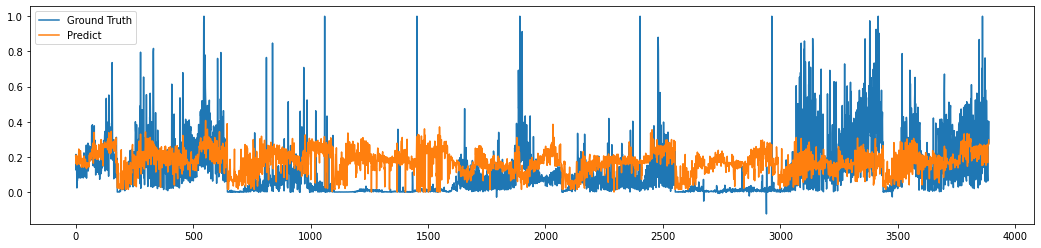

122/122 [==============================] - 0s 478us/step - loss: 0.3876 - accuracy: 0.0021
Accuracy: 0.21


In [573]:
predict = city_model.predict(Xc_test)
print("Teste Geral")
printSaveGraph(Xc_test,Yc_test,predict, 'cities_all_test',city_model)

Teste  São Paulo


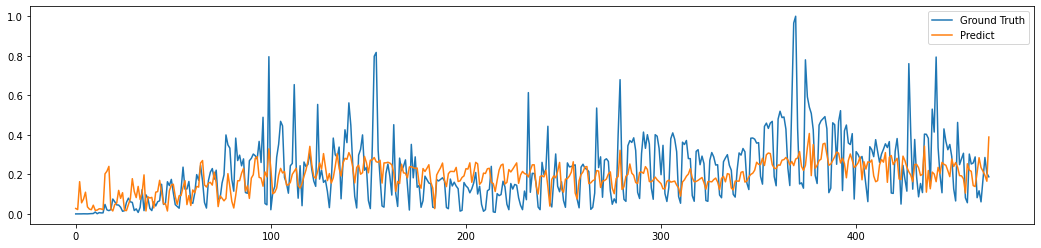

15/15 [==============================] - 0s 784us/step - loss: 0.5064 - accuracy: 0.0000e+00
Accuracy: 0.00


In [574]:
ctName='São Paulo'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'São Paulo')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_São_Paulo_test',city_model)

Teste  Porto Alegre


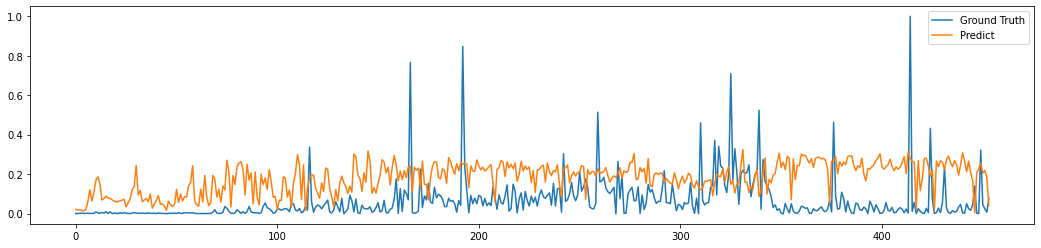

15/15 [==============================] - 0s 784us/step - loss: 0.2977 - accuracy: 0.0110
Accuracy: 1.10


In [583]:
ctName='Porto Alegre'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])

print("Teste ",'Porto Alegre')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Porto_Alegre_test',city_model)

Teste  Curitiba


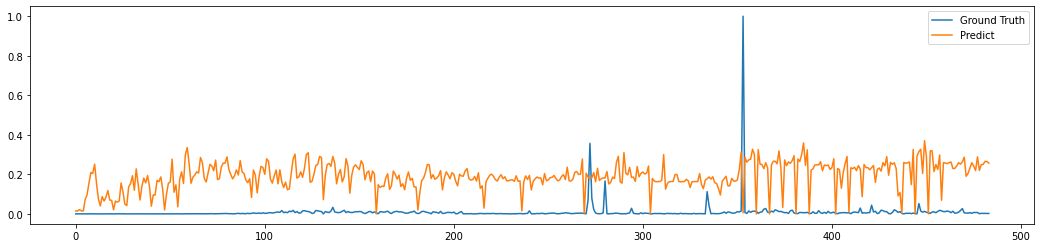

16/16 [==============================] - 0s 931us/step - loss: 0.2364 - accuracy: 0.0021
Accuracy: 0.21


In [576]:
ctName='Curitiba'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Curitiba')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Curitiba_test',city_model)

Teste  Manaus


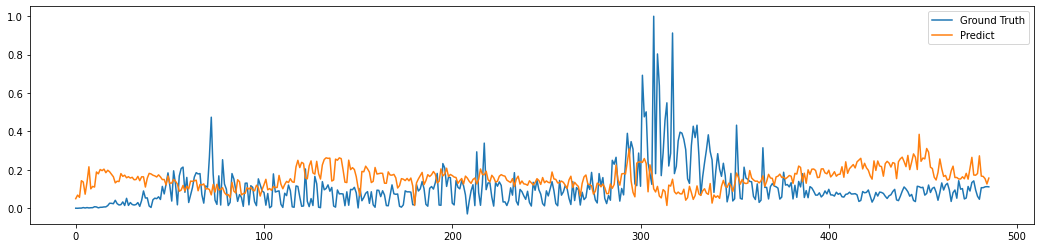

16/16 [==============================] - 0s 731us/step - loss: 0.3749 - accuracy: 0.0000e+00
Accuracy: 0.00


In [577]:
ctName='Manaus'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Manaus')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Manaus_test',city_model)

Teste  Rio de Janeiro


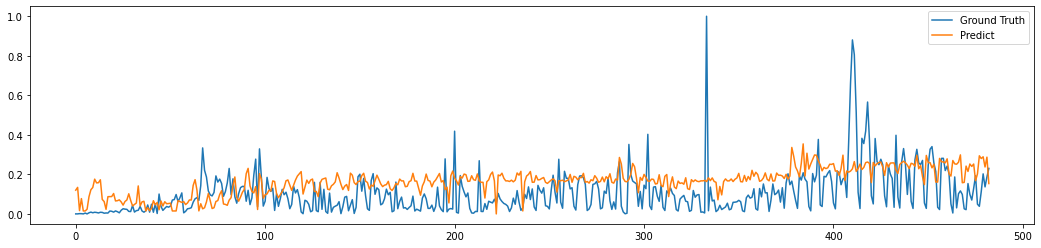

16/16 [==============================] - 0s 798us/step - loss: 0.3446 - accuracy: 0.0000e+00
Accuracy: 0.00


In [578]:
ctName='Rio de Janeiro'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Rio de Janeiro')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Rio_de_Janeiro_test',city_model)

Teste  Natal


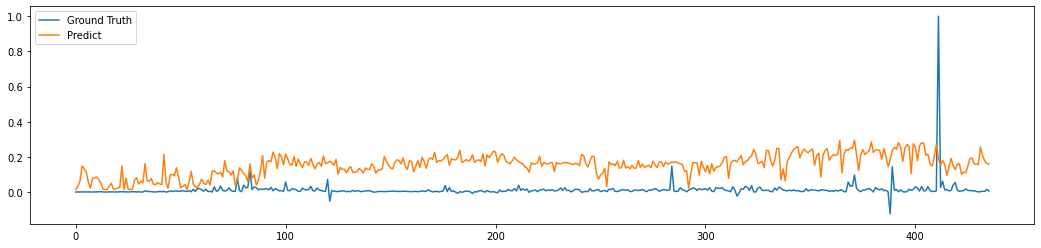

14/14 [==============================] - 0s 844us/step - loss: 0.1896 - accuracy: 0.0023
Accuracy: 0.23


In [579]:
ctName='Natal'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Natal')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Natal_test',city_model)

Teste  Ribeirão Preto


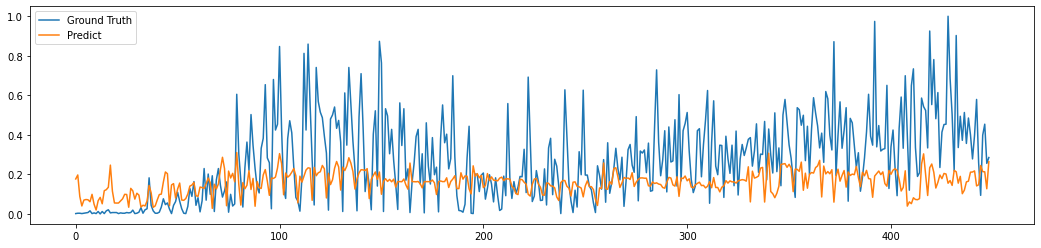

15/15 [==============================] - 0s 926us/step - loss: 0.6159 - accuracy: 0.0022
Accuracy: 0.22


In [580]:
ctName='Ribeirão Preto'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Ribeirão Preto')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Ribeirão_Preto_test',city_model)

Teste  Campinas


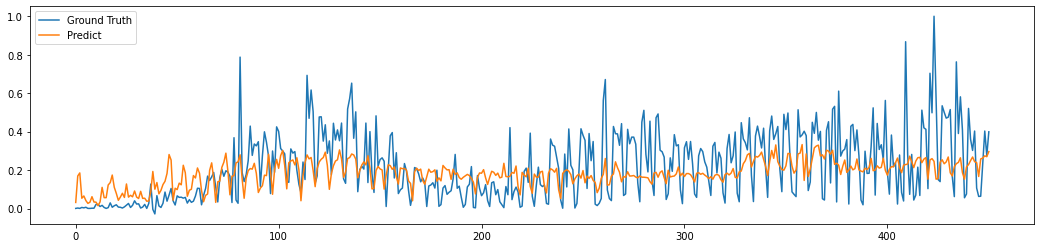

15/15 [==============================] - 0s 784us/step - loss: 0.4981 - accuracy: 0.0000e+00
Accuracy: 0.00


In [581]:
ctName='Campinas'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Campinas')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Campinas_test',city_model)

In [582]:
# import gzip
# import urllib.request
# import io

# # response = urllib.request.urlopen('https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time_changesOnly.csv.gz')
# # compressed_file = io.BytesIO(response.read())

# # print(decompressed_file)



# import requests

# url = 'https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time_changesOnly.csv.gz'
# filename = url.split("/")[-1]
# with open(filename, "wb") as f:
#     r = requests.get(url)
#     f.write(r.content)
    
# gz_file = open(filename, "r")
# decompressed_file = gzip.GzipFile(fileobj=gz_file)
# print(decompressed_file)
# data = pd.read_csv(decompressed_file)
# print(data)